<a href="https://colab.research.google.com/github/daisuke08253649/DeepLearning/blob/main/illustrationidentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00


In [ ]:
import timm
model_list = timm.list_models(pretrained=True)
print(model_list)

['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

In [ ]:
import os
import torch
import torchvision
import pandas as pd


from torch import nn
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [ ]:
#訓練データ
train_img = '/content/drive/MyDrive/DeepLearning/illustrationdiscrimination/train_img'
train_img_label = '/content/drive/MyDrive/DeepLearning/illustrationdiscrimination/train_img_label.csv'

#テストデータ
test_img = '/content/drive/MyDrive/DeepLearning/illustrationdiscrimination/test_img'
test_img_label = '/content/drive/MyDrive/DeepLearning/illustrationdiscrimination/test_img_label.csv'

In [ ]:
class AIillustration(Dataset):
    def __init__(self, img_label, img_dir, transform=None):
        self.img_label = pd.read_csv(img_label)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_label)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_label.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_label.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = AIillustration(train_img_label, train_img, train_transform)
test_dataset = AIillustration(test_img_label, test_img, test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=True)

print(len(train_dataset))
print(len(test_dataset))

1100
150


In [ ]:
device='cuda:0'
#'vit_base_patch16_224.mae'
model = timm.create_model('vit_base_patch16_clip_224.openai_ft_in12k_in1k', pretrained=True, num_classes=2)
model = model.to(device)

lr = 1e-5
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []
accuracy_list = []
count_epoch = 0

In [ ]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for input, label in train_dataloader:
        optimizer.zero_grad()
        input = input.to(device)
        label = label.to(device)
        train_output = model(input)
        train_loss = criterion(train_output, label)
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()

    with torch.no_grad():
        model.eval()
        test_label = 0
        total_test_loss = 0
        accuracy = 0
        for input, label in test_dataloader:
            input = input.to(device)
            label = label.to(device)
            test_output = model(input)
            test_loss = criterion(test_output, label)
            total_test_loss += test_loss.item()
            _, predict = torch.max(test_output.data, 1)
            test_label += label.size(0)
            accuracy += (predict == label).sum()


    train_loss_list.append(total_train_loss / len(train_dataset))
    test_loss_list.append(total_test_loss / test_label)
    accuracy_list.append(float(accuracy) / test_label)

    train = train_loss/len(train_dataset)
    test = test_loss/len(test_dataset)
    acc = float(accuracy)/test_label


    print(f'Epoch:{epoch + 1}, Train_loss:{train}, Test_loss:{test}, Accuracy:{acc}')


count_epoch += 1

Epoch:1, Train_loss:3.931655010092072e-05, Test_loss:0.0001499400386819616, Accuracy:0.9466666666666667
Epoch:2, Train_loss:4.275753326510312e-06, Test_loss:0.00026882177917286754, Accuracy:0.94
Epoch:3, Train_loss:2.559835593274329e-06, Test_loss:0.0006049926159903407, Accuracy:0.94
Epoch:4, Train_loss:7.78919741151185e-07, Test_loss:5.5336084187729284e-05, Accuracy:0.98
Epoch:5, Train_loss:4.490207174967509e-07, Test_loss:9.229080751538277e-05, Accuracy:0.96
Epoch:6, Train_loss:3.519832034726278e-07, Test_loss:4.748981609736802e-06, Accuracy:0.9666666666666667
Epoch:7, Train_loss:2.2739725125120458e-07, Test_loss:0.00607771473005414, Accuracy:0.9666666666666667
Epoch:8, Train_loss:1.9472534518172324e-07, Test_loss:8.097770478343591e-05, Accuracy:0.96
Epoch:9, Train_loss:2.1094548685596237e-07, Test_loss:0.0016648628516122699, Accuracy:0.96
Epoch:10, Train_loss:2.1460580512666638e-07, Test_loss:0.0007618364761583507, Accuracy:0.96
Epoch:11, Train_loss:1.6057320806339703e-07, Test_loss

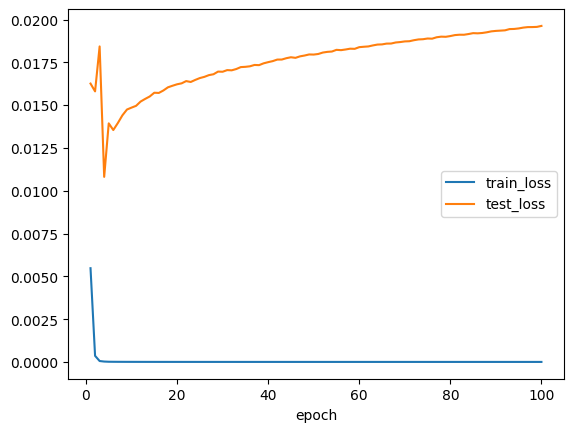

In [ ]:
plt.figure()
plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label='train_loss')
plt.plot(range(1, len(test_loss_list)+1), test_loss_list, label='test_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

予測が正解しているデータ:10


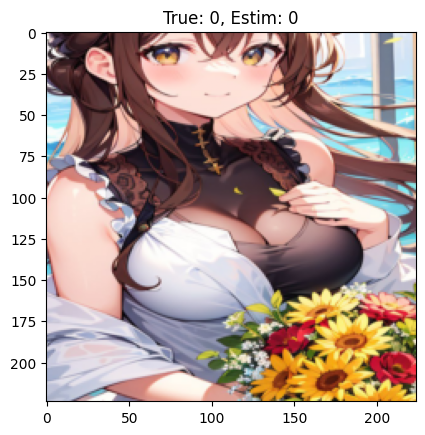

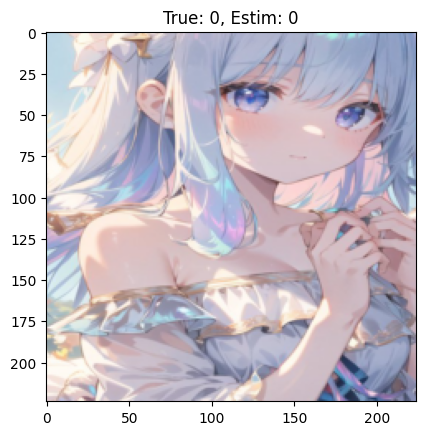

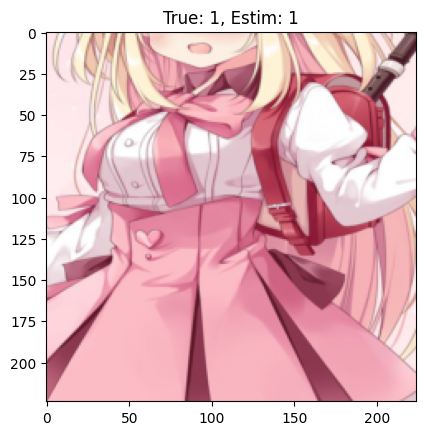

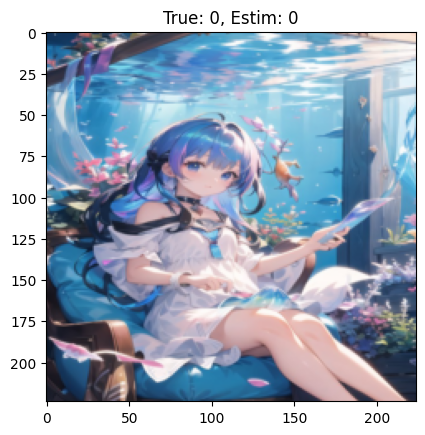

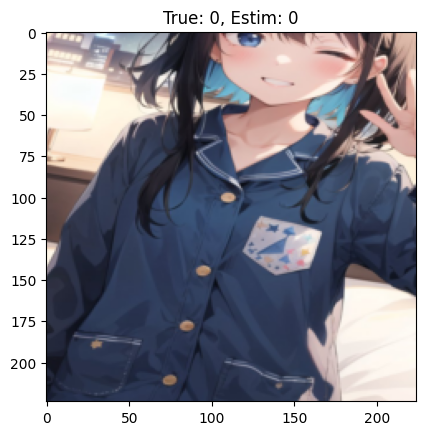

In [ ]:
from torch.autograd import Variable

test_iter = iter(test_dataloader)
true_list = []
false_list = []
input, label = next(test_iter)
output = model(Variable(input.cuda()))
_, predict = torch.max(output.data, 1)

for idx in range(len(label)):
    lst = [input[idx], label[idx], predict[idx]]
    if int(label[idx]) == int(predict[idx]):
        true_list.append(lst)
    else:
        false_list.append(lst)

print(f'予測が正解しているデータ:{len(true_list)}')
for idx, tlst in enumerate(true_list[:5]):
    plt.figure(idx+1)
    image = tlst[0].cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = image.transpose((1, 2, 0))
    plt.imshow(image, cmap='Blues')
    plt.title('True: {}, Estim: {}'.format(tlst[1], tlst[2]))

予測が不正解のデータ:1


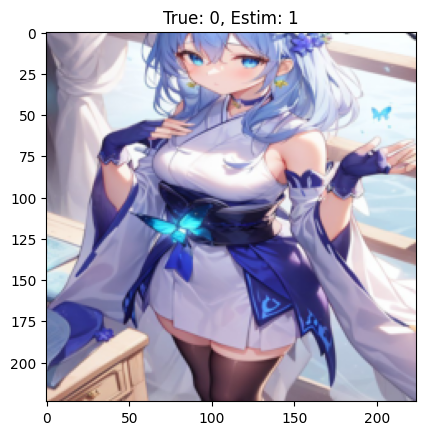

In [ ]:
print(f'予測が不正解のデータ:{len(false_list)}')
for idx, flst in enumerate(false_list[:5]):
    plt.figure(idx+1)
    image = flst[0].cpu().numpy()
    if image.ndim == 3 and image.shape[0] == 3:
        image = image.transpose((1, 2, 0))
    plt.imshow(image, cmap='Reds')
    plt.title('True: {}, Estim: {}'.format(flst[1], flst[2]))

In [ ]:
#モデル保存
torch.save(model, 'illustrationidentification_model.pth')

In [ ]:
#モデルロード
model = torch.load('./保存されたモデルのパス')
model.eval()